## Code Report-Part1
***
This part performs data cleaning, feature engineering, and model training (including Logistic Regression, Random Forest, and LightGBM), evaluates the performance of different models, extracts important features, and ultimately selects the best model (LightGBM) for further feature exploration.

**1.Libraries Import**

Import Python libraries for Data Processing, Visualization, Machine Learning, and Statistical Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, recall_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import gc
import os

import warnings
warnings.filterwarnings('ignore')

**2. Data Cleaning and Feature Engineering**

We first clean and enhance the raw data to provide high-quality input for machine learning models. It involves several key steps: handling missing values, converting categorical variables, creating new features, and merging multiple datasets to improve the model's performance.

In [2]:
def generate_clean_data_all():
    application_train = pd.read_csv(r'C:\Users\26706\OneDrive - HKUST Connect\桌面\data\application_train.csv')
    application_test = pd.read_csv(r'C:\Users\26706\OneDrive - HKUST Connect\桌面\data\application_test.csv')
    previous_application = pd.read_csv(r'C:\Users\26706\OneDrive - HKUST Connect\桌面\data\previous_application.csv')
    installments_payments = pd.read_csv(r'C:\Users\26706\OneDrive - HKUST Connect\桌面\data\installments_payments.csv')
    bureau_balance = pd.read_csv(r'C:\Users\26706\OneDrive - HKUST Connect\桌面\data\bureau_balance.csv')
    bureau = pd.read_csv(r'C:\Users\26706\OneDrive - HKUST Connect\桌面\data\bureau.csv')
    HomeCredit_columns_description = pd.read_csv(r'C:\Users\26706\OneDrive - HKUST Connect\桌面\data\HomeCredit_columns_description.csv', encoding='ISO-8859-1')

    def remove_missingvalue_columns(train, test, threshold = 0):
        train_miss = pd.DataFrame(train.isnull().sum())
        train_miss['percent'] = 100 * train_miss[0] / len(train)
        test_miss = pd.DataFrame(test.isnull().sum())
        test_miss['percent'] = 100 * test_miss[0] / len(test)

        missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
        missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])

        missing_columns = list(set(missing_train_columns + missing_test_columns))
        train = train.drop(columns = missing_columns)
        test = test.drop(columns = missing_columns)

        print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
        if (missing_train_columns == missing_test_columns):
            print('The columns deleted from the test set and the training set are the same.')
        return train, test

    train, test = remove_missingvalue_columns(application_train, application_test, 60)

    def column_type(df):
        category_list = train.select_dtypes(include=['object']).columns.tolist()
        for column in train.select_dtypes(include=['int64', 'float64']).columns:
            if train[column].nunique() == 2 and set(train[column]) == {0, 1}:
                category_list.append(train[column].name)
        for column in df.columns[df.columns.isin(category_list)]:
            df[column] = df[column].astype('category')

    column_type(test); column_type(train)

    def variable_clean(df, train):
        DOCUMENT_list = [col for col in df.columns if 'FLAG_DOCUMENT_' in col]
        df['FLAG_DOCUMENT'] = df[DOCUMENT_list].astype(int).sum(axis=1)

        DAYS_list = [col for col in df if 'DAYS_' in col]
        YEARS_list = [item.replace('DAYS_', 'YEARS_') if 'DAYS_' in item else item for item in DAYS_list]
        df[YEARS_list] = -df[DAYS_list]/365

        NOT_WORK_LIVE_list = [col for col in df.columns if ('_NOT_WORK' in col or '_NOT_LIVE' in col)]
        df['NOT_WORK_LIVE'] = df[NOT_WORK_LIVE_list].astype('int64').apply(lambda row: 1 if row.any() else 0, axis=1).astype('category')

        EXT_SOURCE_list = [col for col in df.columns if 'EXT_SOURCE_' in col]
        df['EXT_SOURCE'] = df[EXT_SOURCE_list].mean(axis=1)

        BUILDING_list = HomeCredit_columns_description[HomeCredit_columns_description['Description'].str.contains('building where the client lives')]['Row'].tolist()
        BUILDING_list = list(set(BUILDING_list).intersection(set(df.columns)))

        columns_to_drop = DOCUMENT_list + DAYS_list + ['REGION_RATING_CLIENT'] + NOT_WORK_LIVE_list + EXT_SOURCE_list + BUILDING_list
        df = df.drop(columns=columns_to_drop)

        df.replace('XNA', np.nan, inplace=True)
        for column in df.select_dtypes(include=['int64', 'float64']).columns:
            df[column].fillna(0, inplace=True)

        df_copy = df.copy()
        for column in df_copy.select_dtypes(include=['category']).columns:
            mode_value = train[column].mode()[0]
            df_copy[column].fillna(mode_value, inplace=True)

        dummy_list = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'WEEKDAY_APPR_PROCESS_START',
                      'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_TYPE_SUITE',
                      'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
        df_copy = pd.concat([df_copy, pd.get_dummies(df_copy[dummy_list], prefix=dummy_list, drop_first=True)], axis=1)
        df_copy = df_copy.drop(columns=dummy_list)

        return df_copy

    df_train = variable_clean(train, train)
    df_test = variable_clean(test, train)

    train_labels = df_train['TARGET']
    df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)
    df_train['TARGET'] = train_labels
    print('------------------application data done!')

    # ================ user id identify - previous default ====================
    # -------------------------------------------------------------------------
    prev_app = previous_application[['SK_ID_CURR', 'DAYS_DECISION']].drop_duplicates()
    app_train = application_train[['SK_ID_CURR', 'DAYS_BIRTH', 'CODE_GENDER']]
    app_test = application_test[['SK_ID_CURR', 'DAYS_BIRTH', 'CODE_GENDER']]
    prev_app = pd.merge(prev_app, pd.concat([app_train, app_test], axis=0), how='left', on='SK_ID_CURR')
    prev_app['DAYS_BIRTH_PREV'] = prev_app['DAYS_BIRTH'] - prev_app['DAYS_DECISION']
    prev_app = prev_app.sort_values(by=['SK_ID_CURR', 'DAYS_DECISION']).reset_index()
    prev_app_grouped = prev_app.groupby('SK_ID_CURR')['DAYS_DECISION'].diff().reset_index(name='DAYS_DECISION_DIFF')
    prev_app = prev_app.merge(prev_app_grouped, left_index=True, right_index=True, how='left')
    prev_app['DAYS_DECISION_DIFF'] = -prev_app['DAYS_DECISION_DIFF']
    prev_app = prev_app[['SK_ID_CURR', 'CODE_GENDER', 'DAYS_DECISION', 'DAYS_BIRTH', 'DAYS_DECISION_DIFF', 'DAYS_BIRTH_PREV']]

    prev_app_1 = prev_app[['SK_ID_CURR', 'CODE_GENDER', 'DAYS_DECISION', 'DAYS_BIRTH']]
    prev_app_2 = prev_app[['SK_ID_CURR', 'CODE_GENDER', 'DAYS_DECISION_DIFF', 'DAYS_BIRTH_PREV']]
    prev_app_2.columns = prev_app_1.columns
    merged = prev_app_1.merge(prev_app_2, on=['CODE_GENDER', 'DAYS_DECISION', 'DAYS_BIRTH'], how='inner')

    pairs = merged[['SK_ID_CURR_x', 'SK_ID_CURR_y']]
    pairs = pairs.copy()
    pairs['x_target'] = pairs['SK_ID_CURR_x'].map(train.set_index('SK_ID_CURR')['TARGET'])
    pairs['y_target'] = pairs['SK_ID_CURR_y'].map(train.set_index('SK_ID_CURR')['TARGET'])

    df_birth = pd.concat([app_train, app_test], axis=0)
    pairs['x_birth'] = pairs['SK_ID_CURR_x'].map(df_birth.set_index('SK_ID_CURR')['DAYS_BIRTH'])
    pairs['y_birth'] = pairs['SK_ID_CURR_y'].map(df_birth.set_index('SK_ID_CURR')['DAYS_BIRTH'])

    combined_series = pd.concat([pairs['SK_ID_CURR_x'], pairs['SK_ID_CURR_y']], ignore_index=True)
    combined_unique = combined_series.drop_duplicates().reset_index()

    birth_data = df_birth[df_birth['SK_ID_CURR'].isin(combined_unique[0].tolist())][['SK_ID_CURR', 'DAYS_BIRTH']]
    result_df = pd.DataFrame({'SK_ID_CURR': combined_unique[0].tolist(), 'prev_default': np.nan})

    for i, row in birth_data.iterrows():
        curr_SK_ID_CURR = row['SK_ID_CURR']
        birth = row['DAYS_BIRTH']

        df = pairs[(pairs['SK_ID_CURR_x'] == curr_SK_ID_CURR) | (pairs['SK_ID_CURR_y'] == curr_SK_ID_CURR)]
        df2 = df[(df['x_birth'] < birth) | (df['y_birth'] < birth)]

        x_condition = df2['x_birth'] == birth
        y_condition = df2['y_birth'] == birth

        df2 = df2.copy()
        df2['prev_default'] = np.where(x_condition, df2['y_target'], np.where(y_condition, df2['x_target'], None))
        prev_default = df2['prev_default'].sum()

        result_df.loc[result_df['SK_ID_CURR'] == curr_SK_ID_CURR, 'prev_default'] = prev_default

    df_train = df_train.merge(result_df, how = 'left', on = 'SK_ID_CURR')
    df_test = df_test.merge(result_df, how = 'left', on = 'SK_ID_CURR')
    df_train.fillna(0, inplace=True); df_test.fillna(0, inplace=True)
    print('------------------previous default done!')

    # ==================== previous_application table==========================
    # -------------------------------------------------------------------------
    installments_payments['DEFAULT_DAY']=installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
    tem =installments_payments[installments_payments['DEFAULT_DAY'] > 0]
    tem = tem.loc[: ,['SK_ID_CURR','DEFAULT_DAY']]
    default_days_agg = tem.groupby('SK_ID_CURR', as_index = False).agg({ 'DEFAULT_DAY' : ['sum', 'count']})
    default_days_agg.columns = ['SK_ID_CURR', 'DEFAULT_DAY_SUM', 'DEFAULT_DAY_COUNT']

    installments_payments['DEFAULT_AMT']=installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']
    tem =installments_payments[installments_payments['DEFAULT_AMT'] > 0]
    tem = tem.loc[: ,['SK_ID_CURR','DEFAULT_AMT']]
    default_AMT_agg = tem.groupby('SK_ID_CURR', as_index = False).agg({ 'DEFAULT_AMT' : ['sum', 'count']})
    default_AMT_agg.columns = ['SK_ID_CURR', 'DEFAULT_AMT_SUM', 'DEFAULT_AMT_COUNT']

    df_train = df_train.merge(default_days_agg, how = 'left', on = 'SK_ID_CURR')
    df_test = df_test.merge(default_days_agg, how = 'left', on = 'SK_ID_CURR')

    df_train = df_train.merge(default_AMT_agg, how = 'left', on = 'SK_ID_CURR')
    df_test = df_test.merge(default_AMT_agg, how = 'left', on = 'SK_ID_CURR')

    def one_hot_encoder(df, nan_category = True):
        original_cols = list(df.columns)
        categorial_cols = [col for col in df.columns if df[col].dtypes == 'object']
        df = pd.get_dummies(df, columns = categorial_cols, dummy_na = nan_category, drop_first=True)
        new_columns = [i for i in df.columns if i not in original_cols]
        return df, new_columns

    previous_app = previous_application
    previous_app_numeric = previous_app.select_dtypes(include=['number'])
    missings = previous_app_numeric.loc[:,previous_app_numeric.isna().mean() >= 0.6]
    highly_missing_features = missings.columns
    previous_app.drop(highly_missing_features, axis=1, inplace=True)

    previous_app_obj = previous_app.dtypes[previous_app.dtypes == 'object'].index
    previous_app[previous_app_obj].apply(pd.Series.nunique, axis = 0)
    previous_app, previous_app_cat = one_hot_encoder(previous_app)

    NA_list = [col for col in previous_app.columns if 'XNA' in col or 'nan' in col or 'XAP' in col]
    previous_app_cat = list(set(NA_list).symmetric_difference(set(previous_app_cat)))
    previous_app = previous_app.drop(columns=NA_list)
    cat_agg = { }
    for i in previous_app_cat:
        cat_agg[i] = 'sum'

    num_agg = {
        'AMT_ANNUITY': ['min','max','mean'],
        'AMT_APPLICATION':['min','max','mean'],
        'AMT_CREDIT':['min','max','mean'],
        'AMT_DOWN_PAYMENT':['min','max','mean'],
        'AMT_GOODS_PRICE':['min','max','mean'],
        'HOUR_APPR_PROCESS_START':['min','max','mean'],
        'RATE_DOWN_PAYMENT':['min','max','mean'],
        'DAYS_DECISION':['min','max','mean'],
        'CNT_PAYMENT':['sum','mean']
    }
    previous_application_agg = previous_app.groupby('SK_ID_CURR', as_index = False).agg({**cat_agg, **num_agg})
    previous_application_agg.columns = ['_'.join(col) for col in previous_application_agg.columns.values]
    previous_application_agg.columns = [col.upper() for col in previous_application_agg.columns.values]
    previous_application_agg.rename(columns={'SK_ID_CURR_': 'SK_ID_CURR'}, inplace=True)

    df_train = df_train.merge(previous_application_agg, how = 'left', on = 'SK_ID_CURR')
    df_test = df_test.merge(previous_application_agg, how = 'left', on = 'SK_ID_CURR')
    df_train.fillna(0, inplace=True); df_test.fillna(0, inplace=True)
    print('-----------------previous application done!')

    # =========================== bureau table ==============================
    # -----------------------------------------------------------------------

    b_obj = bureau.dtypes[bureau.dtypes == 'object'].index
    bb_obj = bureau_balance.dtypes[bureau_balance.dtypes == 'object'].index
    bureau[b_obj].apply(pd.Series.nunique, axis = 0)
    bureau_balance[bb_obj].apply(pd.Series.nunique, axis = 0)

    b, b_cat = one_hot_encoder(bureau)
    bb, bb_cat = one_hot_encoder(bureau_balance)
    NA_list = [col for col in b.columns if 'nan' in col]
    b_cat = list(set(NA_list).symmetric_difference(set(b_cat)))
    b = b.drop(columns=NA_list)
    NA_list = [col for col in bb.columns if 'nan' in col]
    bb_cat = list(set(NA_list).symmetric_difference(set(bb_cat)))
    bb = bb.drop(columns=NA_list)

    b = b.merge(bb, how= 'left', on='SK_ID_BUREAU')
    b.drop(['SK_ID_BUREAU'], axis= 1, inplace= True)
    tem = b.columns.tolist()
    num_agg = { }
    for i in tem:
        if i != 'SK_ID_CURR':
            num_agg[i] = ['min', 'max', 'mean', 'var', 'sum']

    bureau_agg = b.groupby('SK_ID_CURR', as_index = False).agg(num_agg)

    tem = [ ]
    tem.append('SK_ID_CURR')
    for i in bureau_agg.columns.tolist():
        if i[0] != 'SK_ID_CURR':
            tem.append('bureau' + '_' + str(i[0]) + '_' + str(i[1]))

    bureau_agg.columns = pd.Index(tem)
    df_train = df_train.merge(bureau_agg, how = 'left', on = 'SK_ID_CURR')
    df_test = df_test.merge(bureau_agg, how = 'left', on = 'SK_ID_CURR')
    df_train.fillna(0, inplace=True); df_test.fillna(0, inplace=True)
    print('--------------------- bureau data done!')

    return df_train, df_test

train_clean, test_clean = generate_clean_data_all()
train_clean.to_csv('train_clean.csv')
test_clean.to_csv('test_clean.csv')

There are 17 columns with greater than 60% missing values.
The columns deleted from the test set and the training set are the same.
------------------application data done!
------------------previous default done!
-----------------previous application done!
--------------------- bureau data done!


**3. Model Training Framework**

Then we use a flexible machine learning pipeline that supports various models like Logistic Regression, Random Forest, and LightGBM. It uses KFold cross-validation for model training, ensuring robust evaluation. The framework handles data preprocessing tasks such as missing value imputation and feature scaling, followed by model training, feature importance calculation, and performance evaluation using metrics like AUC.

In [3]:
def model_construct(train_data, test_data, model, n_folds = 5):
    """
    Train and evaluate a given machine learning model. Supports logistic regression, random forest, and LightGBM models.
    
    :param model: The model to use ('logistic', 'RandomForest', 'lgbm')
    :param train_data: Training dataset
    :param test_data: Test dataset
    :param n_folds: The number of folds for cross-validation, default is 5
    :return: Returns predictions, feature importance, validation scores, and out-of-fold predictions
    """
    
    # Extract 'SK_ID_CURR' (ID) column from train and test datasets
    train_ids = train_data['SK_ID_CURR']
    test_ids = test_data['SK_ID_CURR']

    # Drop 'TARGET' and 'SK_ID_CURR' columns from train data, and 'SK_ID_CURR' from test data to prepare feature data
    x_train = train_data.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    x_test = test_data.drop('SK_ID_CURR', axis=1)
    y_train = train_data['TARGET']

    # Extract feature names for later use
    feature_names = list(x_train.columns)

    # Convert to numpy arrays
    x_train = np.array(x_train)
    x_test = np.array(x_test)

    # Preprocessing: handle missing values and feature scaling
    imputer = SimpleImputer(strategy='most_frequent')  # Fill missing data with the most frequent value
    scaler = MinMaxScaler(feature_range=(0, 1))  # Scale features to the range [0, 1]

    # Apply imputation and scaling to both training and test data
    x_train = imputer.fit_transform(x_train)
    x_test = imputer.transform(x_test)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Output the shape of training and testing data
    print('Training Data Shape: ', x_train.shape)
    print('Testing Data Shape: ', x_test.shape)

    # Create the KFold cross-validation object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 9170)

    # Initialize feature importance values
    feature_importance_values = np.zeros(len(feature_names))

    # Initialize arrays for test predictions and out-of-fold predictions
    test_predictions = np.zeros(x_test.shape[0])
    out_of_fold = np.zeros(x_train.shape[0])

    # Initialize lists to record training and validation scores
    valid_scores = []
    train_scores = []

    # If the model is logistic regression
    if model == 'logistic':
        # Perform KFold cross-validation
        for train_index, valid_index in k_fold.split(x_train):
            # Split the data into training and validation sets
            x_tr, y_tr = x_train[train_index], y_train[train_index]
            x_va, y_va = x_train[valid_index], y_train[valid_index]

            # Train logistic regression model
            lr_model = LogisticRegression(C = 0.0001, random_state=9171)
            lr_model.fit(x_tr, y_tr)

            # Calculate feature importance (using absolute values of regression coefficients)
            feature_importance_values += np.abs(lr_model.coef_[0]) / k_fold.n_splits

            # Make predictions on the test set
            test_predictions += lr_model.predict_proba(x_test)[:, 1] / k_fold.n_splits
            # Make predictions on the validation set
            out_of_fold[valid_index] = lr_model.predict_proba(x_va)[:, 1]

            # Record the AUC scores for training and validation
            train_scores.append(roc_auc_score(y_tr, lr_model.predict_proba(x_tr)[:, 1]))
            valid_scores.append(roc_auc_score(y_va, lr_model.predict_proba(x_va)[:, 1]))

            # Free up memory
            gc.enable()
            del lr_model, x_tr, x_va, y_tr, y_va
            gc.collect()

    # If the model is random forest
    elif model == 'RandomForest':
        # Perform KFold cross-validation
        for train_index, valid_index in k_fold.split(x_train):
            # Split the data into training and validation sets
            x_tr, y_tr = x_train[train_index], y_train[train_index]
            x_va, y_va = x_train[valid_index], y_train[valid_index]

            # Train random forest model
            rf_model = RandomForestClassifier(n_estimators = 100, random_state = 9172, verbose = 1, n_jobs = -1)
            rf_model.fit(x_tr, y_tr)

            # Calculate feature importance
            feature_importance_values += rf_model.feature_importances_ / k_fold.n_splits
            # Make predictions on the test set
            test_predictions += rf_model.predict_proba(x_test)[:, 1] / k_fold.n_splits
            # Make predictions on the validation set
            out_of_fold[valid_index] = rf_model.predict_proba(x_va)[:, 1]

            # Record the AUC scores for training and validation
            train_scores.append(roc_auc_score(y_tr, rf_model.predict_proba(x_tr)[:, 1]))
            valid_scores.append(roc_auc_score(y_va, rf_model.predict_proba(x_va)[:, 1]))

            # Free up memory
            gc.enable()
            del rf_model, x_tr, x_va, y_tr, y_va
            gc.collect()

    # If the model is LightGBM
    elif model == 'lgbm':
        # Perform KFold cross-validation
        for train_index, valid_index in k_fold.split(x_train):
            # Split the data into training and validation sets
            x_tr, y_tr = x_train[train_index], y_train[train_index]
            x_va, y_va = x_train[valid_index], y_train[valid_index]

            # Train LightGBM model
            lgb_model = lgb.LGBMClassifier(n_estimators=1000,
                                           objective = 'binary',
                                           learning_rate = 0.05,
                                           reg_alpha = 0.3,
                                           reg_lambda = 0.5,
                                           n_jobs = -1,
                                           random_state = 9173)
            lgb_model.fit(x_tr, y_tr,
                          eval_metric = 'auc',
                          eval_set= [(x_va, y_va), (x_tr, y_tr)],
                          eval_names=['valid', 'train'],
                          callbacks=[lgb.log_evaluation(period=200), lgb.early_stopping(stopping_rounds=100)]
                          )
            best_iteration = lgb_model.best_iteration_

            # Calculate feature importance
            feature_importance_values += lgb_model.feature_importances_ / k_fold.n_splits
            # Make predictions on the test set
            test_predictions += lgb_model.predict_proba(x_test, num_iteration=best_iteration)[:, 1] / k_fold.n_splits
            # Make predictions on the validation set
            out_of_fold[valid_index] = lgb_model.predict_proba(x_va, num_iteration=best_iteration)[:, 1]

            # Record the AUC scores for training and validation
            train_scores.append(lgb_model.best_score_['train']['auc'])
            valid_scores.append(lgb_model.best_score_['valid']['auc'])

            # Free up memory
            gc.enable()
            del lgb_model, x_tr, x_va, y_tr, y_va
            gc.collect()

    else:
        raise ValueError('Only support logistic, randomforest, lgbm model')

    # Prepare submission data: including test predictions and feature importance
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Calculate the overall AUC score
    valid_auc = roc_auc_score(y_train, out_of_fold)
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Create fold names (KFold + Overall)
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Create a dataframe to show validation and training scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})

    return submission, feature_importance, metrics, out_of_fold

**4. Model Training and Kaggle Evaluation**

The clean datasets (train_clean.csv and test_clean.csv in section 2 ) will be used to train the models. The public_score and private_score are obtained by submitting the model's predictions to Kaggle for scoring based on different model performances.

In [5]:
clean_feature_performance = {}

train = pd.read_csv(r'C:\Users\26706\OneDrive - HKUST Connect\桌面\data\train_clean.csv')
test = pd.read_csv(r'C:\Users\26706\OneDrive - HKUST Connect\桌面\data\test_clean.csv')

non_numeric_columns_train = train.select_dtypes(include=['object']).columns
non_numeric_columns_test = test.select_dtypes(include=['object']).columns

# 2. Convert boolean strings (like 'False' and 'True') to integers
def convert_boolean_columns(df, columns):
    for column in columns:
        if df[column].dtype == 'object':  # If the column is of string type
            # Check if it contains boolean strings, and convert them to 0 and 1
            if df[column].isin(['True', 'False']).all():
                df[column] = df[column].map({'True': 1, 'False': 0})
            else:
                # If it's another categorical type, perform label encoding
                df[column] = df[column].astype('category').cat.codes
    return df

# 3. Convert boolean string columns in both the training and testing sets
train = convert_boolean_columns(train, non_numeric_columns_train)
test = convert_boolean_columns(test, non_numeric_columns_test)

# 4. Data normalization
scaler = StandardScaler()

x_train = scaler.fit_transform(train.drop('TARGET', axis=1))  
x_test = scaler.transform(test)  

# Confirm if the data is cleaned and ready for model training
print(x_train.shape, x_test.shape)


for model_n in ['logistic', 'RandomForest', 'lgbm']:
    submission, feature_importance, metrics, valid_score = model_construct(train_data=train, test_data=test, model=model_n)
    clean_feature_performance[model_n] = {'submission': submission,
                                          'feature_importance': feature_importance,
                                          'metrics': metrics,
                                          'valid_score': valid_score,
                                          'public_score': 0,
                                          'private_score': 0}

    print(f'{model_n} done!')

clean_feature_performance['logistic']['public_score'] = 0.67827
clean_feature_performance['logistic']['private_score'] = 0.68469
clean_feature_performance['logistic']['kfold_train_score'] = clean_feature_performance['logistic']['metrics'].iloc[-1, :]['valid']

clean_feature_performance['RandomForest']['public_score'] = 0.72005
clean_feature_performance['RandomForest']['private_score'] = 0.72219
clean_feature_performance['RandomForest']['kfold_train_score'] = clean_feature_performance['RandomForest']['metrics'].iloc[-1, :]['valid']

clean_feature_performance['lgbm']['public_score'] = 0.76666
clean_feature_performance['lgbm']['private_score'] = 0.76914
clean_feature_performance['lgbm']['kfold_train_score'] = clean_feature_performance['lgbm']['metrics'].iloc[-1, :]['valid']


(307511, 491) (48744, 491)
Training Data Shape:  (307511, 490)
Testing Data Shape:  (48744, 490)
logistic done!
Training Data Shape:  (307511, 490)
Testing Data Shape:  (48744, 490)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0

RandomForest done!
Training Data Shape:  (307511, 490)
Testing Data Shape:  (48744, 490)
[LightGBM] [Info] Number of positive: 19787, number of negative: 226221
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37111
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 463
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080432 -> initscore=-2.436487
[LightGBM] [Info] Start training from score -2.436487
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.817658	train's binary_logloss: 0.226703	valid's auc: 0.778355	valid's binary_logloss: 0.243038
[400]	train's auc: 0.854577	train's binary_logloss: 0.213513	valid's auc: 0.779593	valid's binary_logloss: 0.242464
Early stopping, best iteration is:
[362]	train's auc: 0.8489	train's binary_logloss: 0.215723	valid's auc: 0.779755	val

In [6]:
pd.to_pickle(clean_feature_performance, 'clean_feature_performance.pkl')

**5.Result Analysis**


In [7]:
def plot_feature_importances(df):
    df = df.sort_values('importance', ascending = False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
            df['importance_normalized'].head(15),
            align = 'center', edgecolor = 'k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    return df

def roc_plot(y_true, y_score, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_score, model_name, threshold=0.6):
    # Use sklearn's confusion_matrix function to calculate the confusion matrix
    y_pred = np.where(y_score > threshold, 1, 0)
    cm = confusion_matrix(y_true, y_pred)
    print(f'{model_name} accuracy: ', accuracy_score(y_true, y_pred))
    print(f'{model_name} sensitivity: ', recall_score(y_true, y_pred))
    # Use seaborn to plot the confusion matrix heatmap
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.colorbar()
    classes = [0, 1]
    tick_marks = np.array(range(len(classes)))  # classes is the list of classes
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add numbers to the heatmap
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = str(cm[i, j])
            plt.text(j, i, text, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

clean_feature_performance = pd.read_pickle('clean_feature_performance.pkl')

model_l = ['logistic', 'RandomForest', 'lgbm']


5.1 Model Scores

In [8]:
# model performance with clean data feature
model_clean_per = pd.DataFrame()
for model_n in model_l:
    for sco in ['public_score', 'private_score', 'kfold_train_score']:
        model_clean_per.loc[model_n, sco] = clean_feature_performance[model_n][sco]
model_clean_per

,public_score,private_score,kfold_train_score
logistic,0.67827,0.68469,0.680952
RandomForest,0.72005,0.72219,0.718161
lgbm,0.76666,0.76914,0.776362


We can observe that LightGBM achieves the best performance among the models. Therefore, we will focus on using this model for further in-depth feature engineering in the subsequent stages.

5.2 Feature Importance

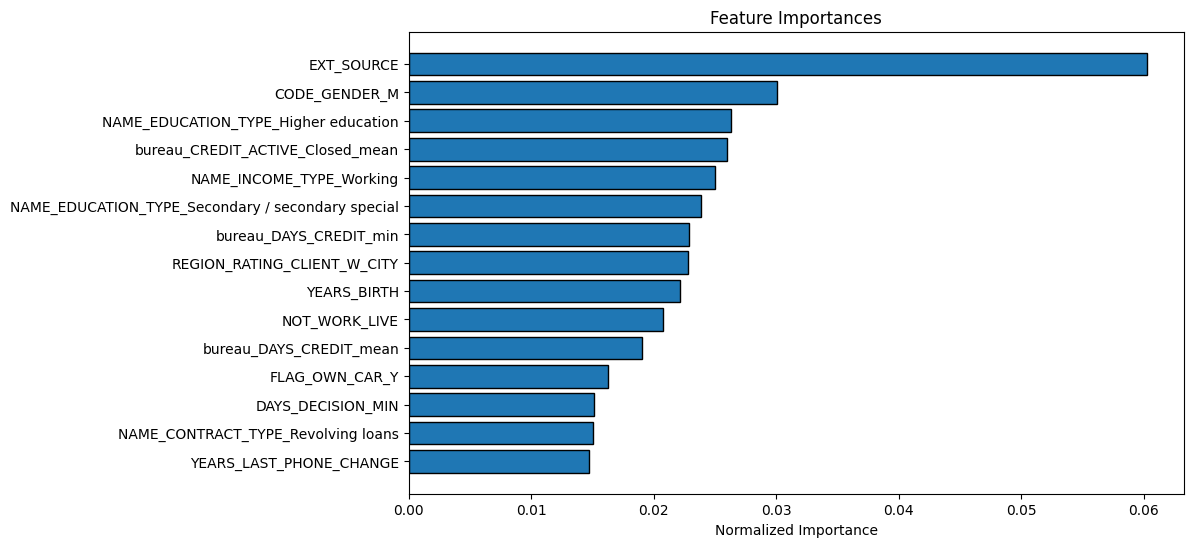

In [9]:
# Logistic regression Model
fi_logit = plot_feature_importances(clean_feature_performance['logistic']['feature_importance'])

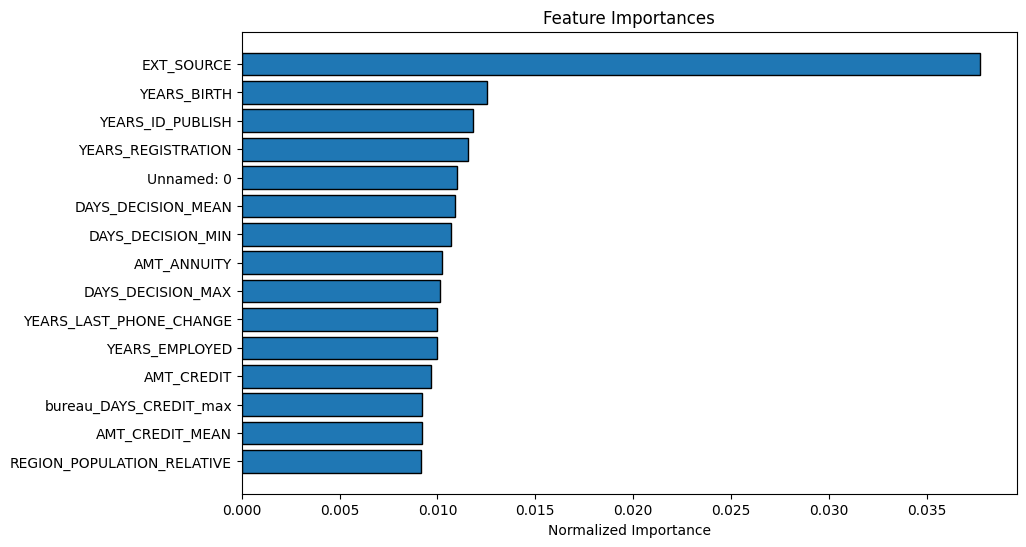

In [10]:
# Random Forest Model
fi_rf = plot_feature_importances(clean_feature_performance['RandomForest']['feature_importance'])

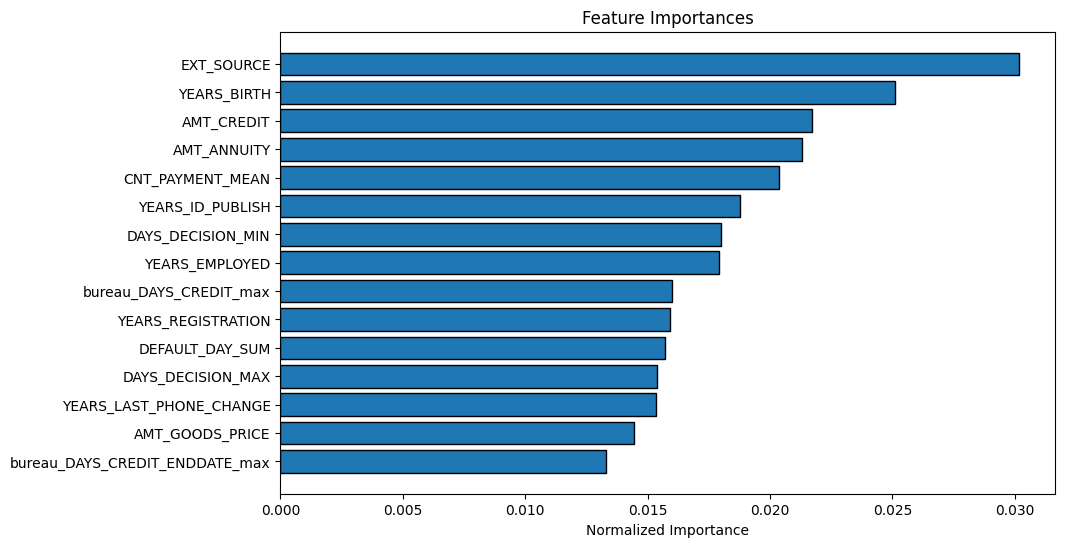

In [11]:
# lgbm
fi_lgbm = plot_feature_importances(clean_feature_performance['lgbm']['feature_importance'])

In [12]:
# Intersection
set(fi_rf.head(30)['feature']).intersection(set(fi_logit.head(30)['feature'])).intersection(set(fi_lgbm.head(30)['feature']))

{'DAYS_DECISION_MEAN',
 'DAYS_DECISION_MIN',
 'EXT_SOURCE',
 'REGION_POPULATION_RELATIVE',
 'YEARS_BIRTH',
 'YEARS_EMPLOYED',
 'YEARS_ID_PUBLISH',
 'YEARS_LAST_PHONE_CHANGE',
 'bureau_DAYS_CREDIT_max'}

By identifying the intersection of the top 30 important features from Random Forest, Logistic Regression, and LightGBM models, we obtained nine key features: DAYS_DECISION_MEAN, DAYS_DECISION_MIN, EXT_SOURCE, REGION_POPULATION_RELATIVE, YEARS_BIRTH, YEARS_EMPLOYED, YEARS_ID_PUBLISH, YEARS_LAST_PHONE_CHANGE, and bureau_DAYS_CREDIT_max. These features will be the focus of further feature engineering and exploration in the subsequent stages.

5.3 Roc plot

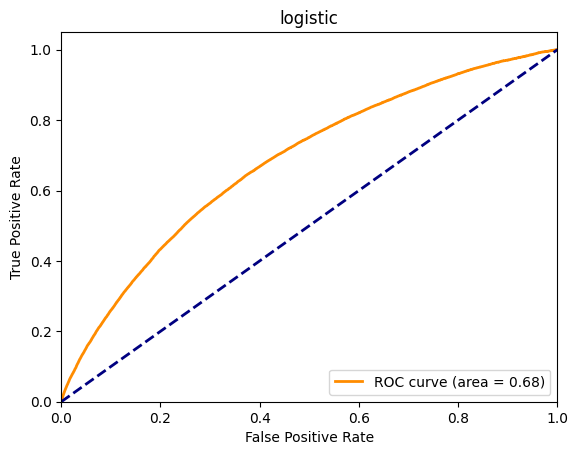

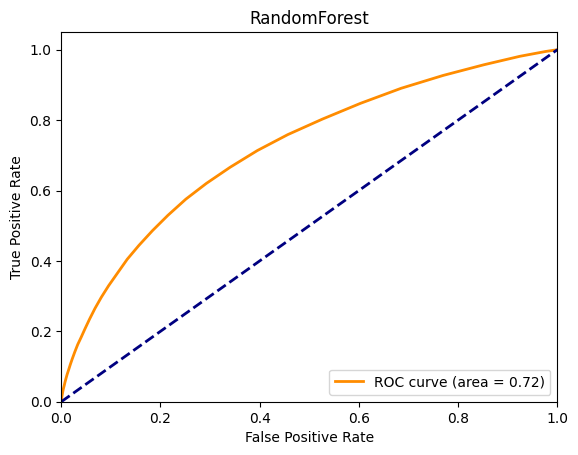

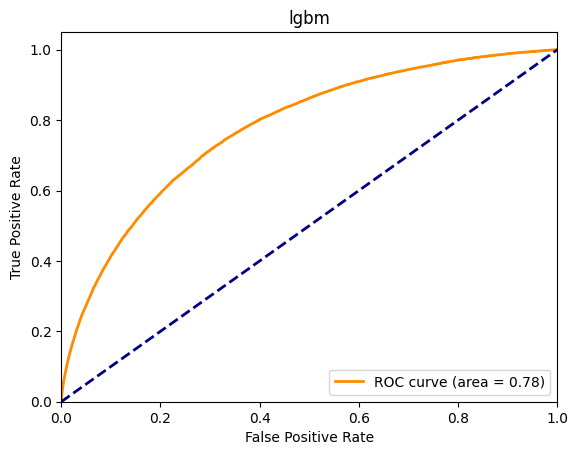

In [13]:
model_l = ['logistic', 'RandomForest', 'lgbm']
for model_n in model_l:
    roc_plot(train['TARGET'], clean_feature_performance[model_n]['valid_score'], model_n)

5.4 Confusion Matrix

logistic accuracy:  0.9192711805431351
logistic sensitivity:  0.0


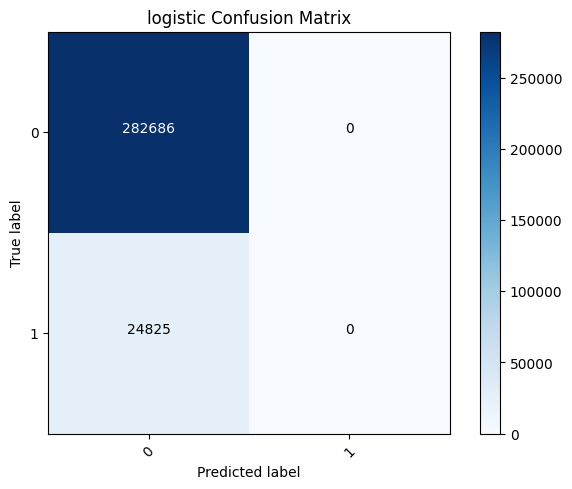

RandomForest accuracy:  0.9192939439564763
RandomForest sensitivity:  0.00028197381671701913


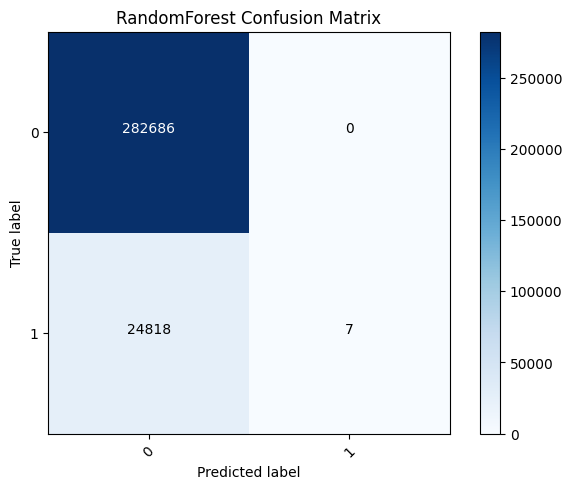

lgbm accuracy:  0.9196581585699374
lgbm sensitivity:  0.011399798590130917


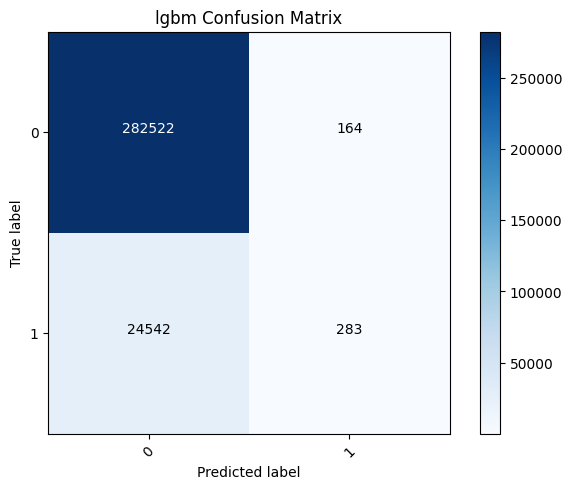

In [14]:
for model_n in model_l:
    plot_confusion_matrix(train['TARGET'], clean_feature_performance[model_n]['valid_score'], model_n)